
# Try out Bayesian update to environmental estimate


In [142]:

# %%
#%%
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
import arviz as az
import arviz.labels as azl
from hierarchical_normal_belk import hierarchical_normal
import itertools
#!! conda install -c conda-forge flox
import flox
from flox.xarray import xarray_reduce # useful in doing multiple coord groupings


In [143]:
rng=np.random.Generator(np.random.PCG64(1234))


In [144]:
size = 160 #size of grid
horz_offest = 10 #offset of grid from 0,0
mean_tempC_Km = 6.5/1000 #mean lapse rate
max_alt_Km = 13 #max altitude in km
#keep lat and long square for ease of matrixing
lat = np.arange(horz_offest, size)
long = np.arange(0, size - horz_offest)
alt = np.arange(0, max_alt_Km)*1000 #in meters


In [145]:
# AR is auto-regressive, MA is moving average; will only use AR 
def sample_AR_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"
    burn_samples = 100
    n_samples=n_samples+burn_samples

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))
    
    return np.array(signal[burn_samples:])
    
def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]



# Baseline thermal along latitude




In [146]:
base_sigma = .05
samp_lat_base = sample_AR_signal(size-horz_offest, 0.5, mu=2, sigma=base_sigma)
samp_lat= pd.DataFrame(samp_lat_base)
print(compute_corr_lag_1(samp_lat_base), samp_lat)


0.4905258250206755             0
0    2.036069
1    2.027572
2    1.993492
3    2.051909
4    2.150573
..        ...
145  2.015571
146  1.946987
147  1.990276
148  1.941792
149  1.953842

[150 rows x 1 columns]



# Extend along longitude


In [147]:
#use latitudes as mean for AR signal along longitudes
samp = sample_AR_signal(size-horz_offest, 0.75, mu=samp_lat, sigma=base_sigma)
samp = pd.DataFrame(samp[:, :, 0])
print(compute_corr_lag_1(samp.iloc[:,0]),compute_corr_lag_1(samp.iloc[0,:]))


0.7552411430209427 0.4905258250206755


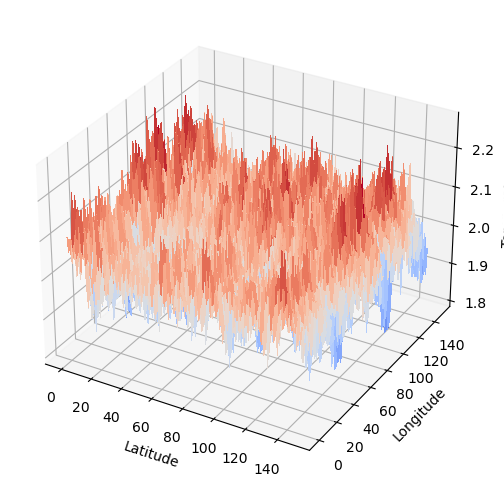

In [148]:

def plot_temperature_env(samp):
    x2, y2 = np.meshgrid(samp.index.values, samp.columns.values)
    plt.figure(figsize=(6,5))
    axes = plt.axes(projection='3d')
    axes.plot_surface(x2, y2,samp.values,cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
    axes.set_ylabel('Longitude')
    axes.set_xlabel('Latitude')
    axes.set_zlabel('Temperature')
    # keeps padding between figure elements
    plt.tight_layout()
    plt.show()

plot_temperature_env(samp)


# Add trend on top of the AR variation -- to baseline thermal


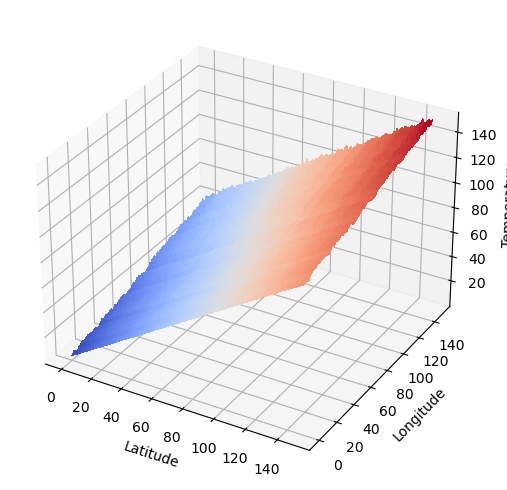

In [149]:
# add MA
lat_inc_slope = 15/100 *5 #deterministic slope of increase in temperature with latitude
lat_inc_max = lat_inc_slope *(size-horz_offest) 
long_inc_mu, long_inc_std = 25/100, .1  #mean and std of increase in temperature with longitude

def add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std):
    lat_inc = np.linspace(0,lat_inc_max, len(samp_lat))
    sample_lat_inc = samp_lat[0] + lat_inc
    sample_lat_inc = pd.DataFrame(sample_lat_inc)
#sample_lat_inc.plot()

    samp_inc = sample_AR_signal(size-horz_offest, corr=0.5, mu=sample_lat_inc)
    long_inc = stats.norm.rvs(loc=long_inc_mu, scale=long_inc_std, size=(size-horz_offest,size-horz_offest), random_state=None)
    long_inc = np.cumsum(long_inc, axis=0)
    samp_inc = pd.DataFrame(samp_inc[:, :, 0]+long_inc)
    return samp_inc

samp_inc = add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std)


plot_temperature_env(samp_inc)



# Extend into atmosphere


In [150]:

#allow for inversion by having random lapse rate at diff altitudes
def add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km):
    tempC_Km = rng.normal(loc=mean_tempC_Km, scale=mean_tempC_Km/10, size=max_alt_Km)
# Temp at altitude = base temp - tempC_km * altitude
    temperature = ( [np.array(samp_inc) 
                 for _ in np.arange(max_alt_Km)]
               -np.broadcast_to(
    tempC_Km * np.arange(max_alt_Km)*1000, (size-horz_offest,size-horz_offest,max_alt_Km)
    ).T
)
    temperature = temperature.T
    return temperature

temp_3D = add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km)


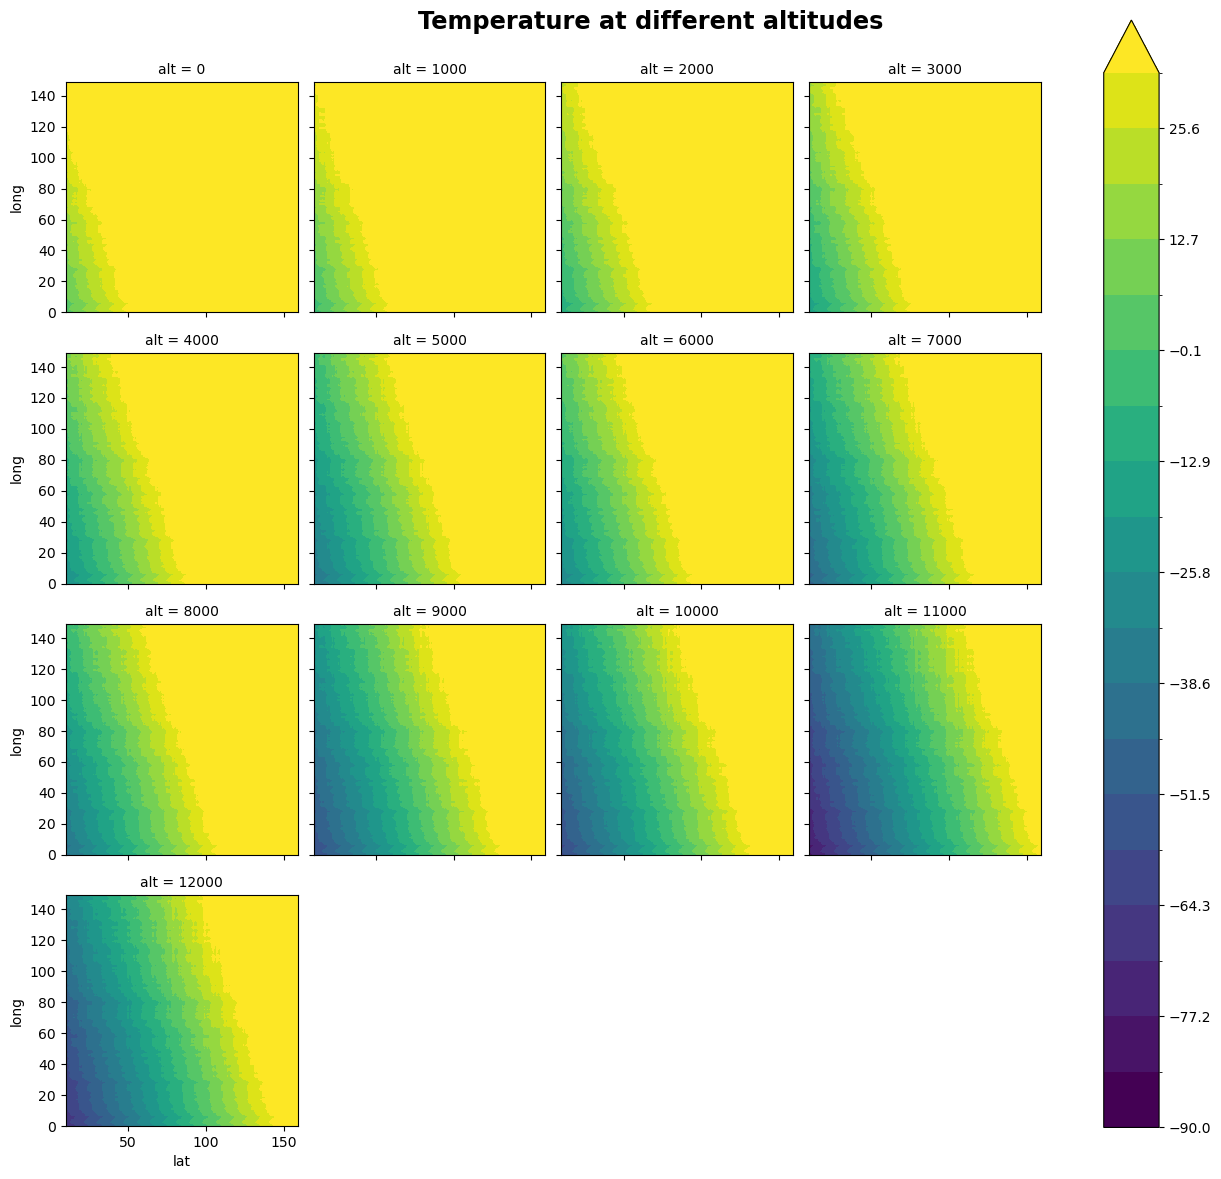

In [151]:

xr_temp_3D = xr.DataArray(temp_3D, dims=['lat', 'long', 'alt'], coords={'lat': lat, 'long': long, 'alt': alt})
fig = xr_temp_3D.plot.contourf(x='lat',y='long',col='alt', col_wrap=4,
                         robust=True, vmin=-90, vmax=32, levels=20)
plt.suptitle('Temperature at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)

xr_tempC_Km=  xr.DataArray(mean_tempC_Km, dims=['alt'], coords={'alt': alt})



# Calculate pressure based on baseline temp field and assumed L; 


In [152]:

#barometric formula
def add_barometric_effects(T = 288.15-273.15, L = 0.0065, H = 0,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598):
    #barometric formula
    #P = P0 * (1 - L * H / T0) ^ (g0 * M / (R * L))
    #P = pressure
    #P0 = pressure at sea level = 101_325.00 Pa
    #L = temperature lapse rate = temperature lapse rate (K/m) in
    #H = altitude (m)
    #T0 = temperature at sea level = reference temperature (K)
    #g0 = gravitational acceleration = gravitational acceleration: 9.80665 m/s2
    #M = molar mass of air = molar mass of Earth's air: 0.0289644 kg/mol
    #R = gas constant = universal gas constant: 8.3144598 J/(mol·K)
    #L = temperature lapse rate
    #T = temperature
    T = T +273.15
    if isinstance(T, xr.core.dataarray.DataArray):
        T0 = T.sel(alt=0)
        
    else:
        T0 = T[0]
        print('used t[0]')
        print(type(T))
    #return P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    return P0 * (T / T0) ** (g0 * M / (R * L.mean()))


pressure = add_barometric_effects(T = xr_temp_3D, 
                                 L = xr_tempC_Km, 
                                 H = xr_temp_3D.alt,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)


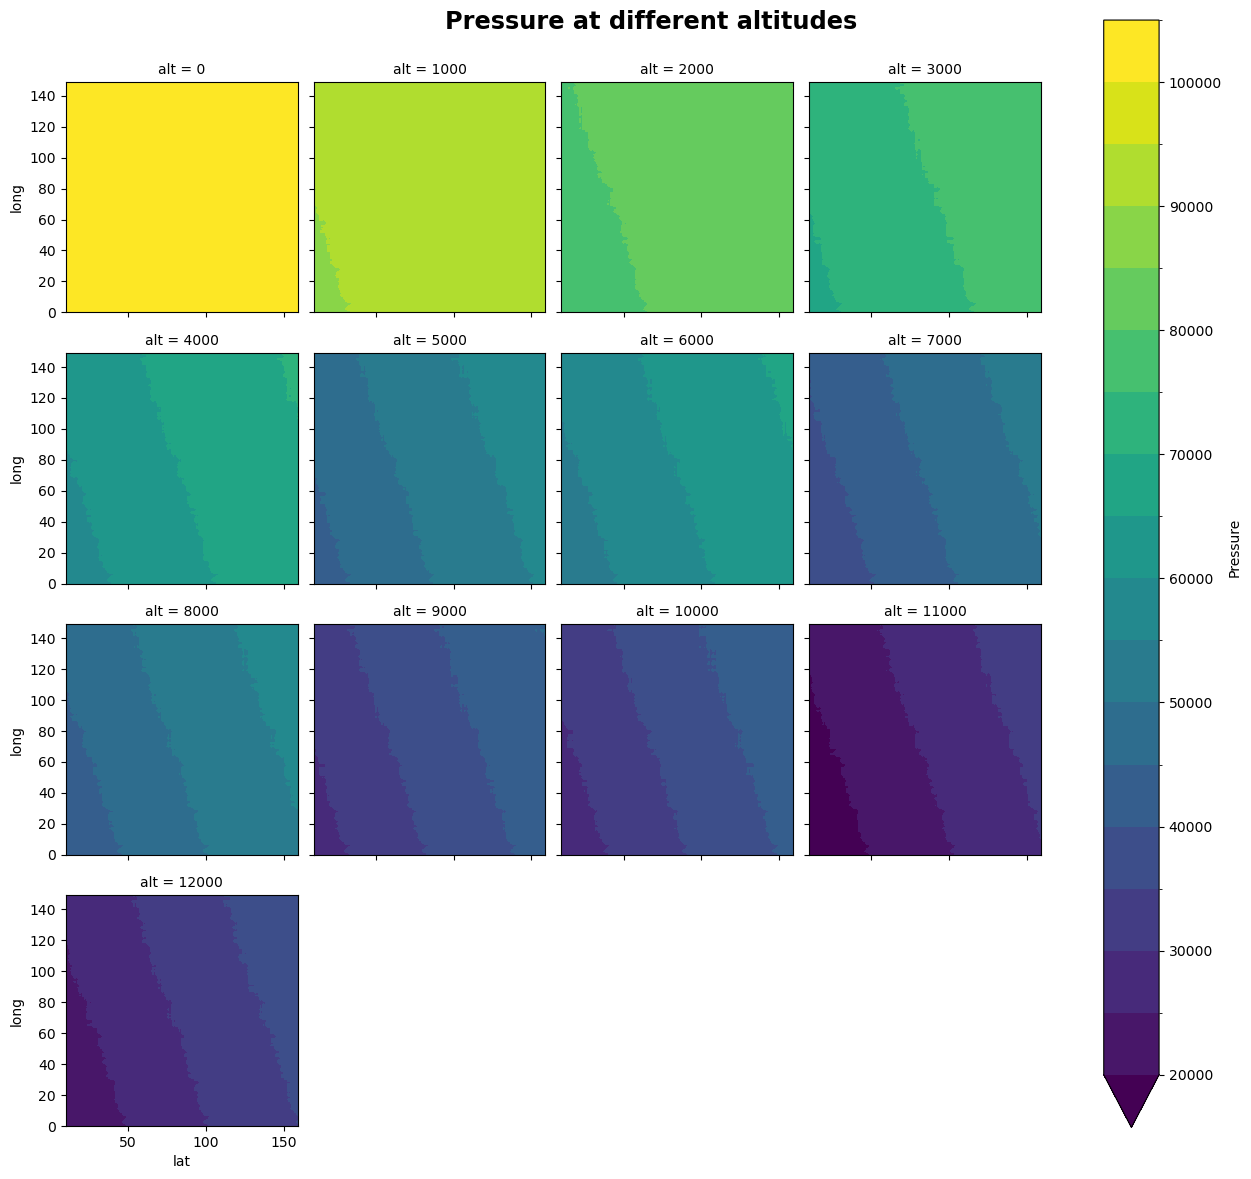

In [153]:

xr_temp_pres = xr.merge(
    [xr_temp_3D.rename("Temperature"), 
     pressure.rename("Pressure")]
     )

xr_temp_pres.Pressure.plot.contourf(x='lat',y='long', col='alt', col_wrap=4,
                         robust=True, levels=20)
plt.suptitle('Pressure at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)



# # make trajectory and get corresponding temp and pres


In [154]:
# make Z = a function of time and  X = sin of time and y = cos of time
time = pd.to_datetime( np.arange(0, 3*60*60, 1), unit='s')
print(time)


DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:01',
               '1970-01-01 00:00:02', '1970-01-01 00:00:03',
               '1970-01-01 00:00:04', '1970-01-01 00:00:05',
               '1970-01-01 00:00:06', '1970-01-01 00:00:07',
               '1970-01-01 00:00:08', '1970-01-01 00:00:09',
               ...
               '1970-01-01 02:59:50', '1970-01-01 02:59:51',
               '1970-01-01 02:59:52', '1970-01-01 02:59:53',
               '1970-01-01 02:59:54', '1970-01-01 02:59:55',
               '1970-01-01 02:59:56', '1970-01-01 02:59:57',
               '1970-01-01 02:59:58', '1970-01-01 02:59:59'],
              dtype='datetime64[ns]', length=10800, freq=None)


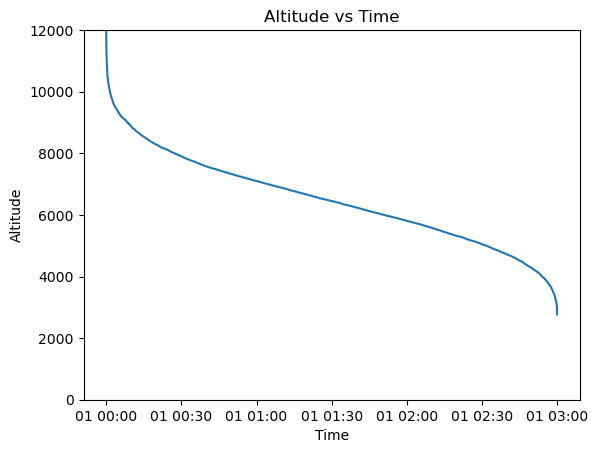

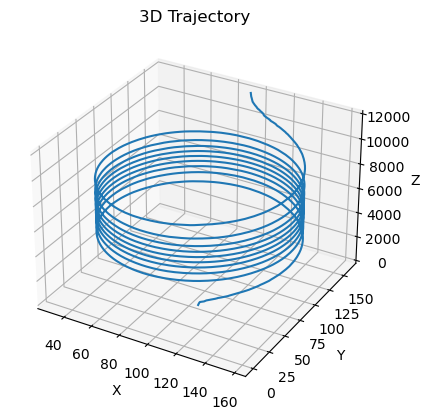

In [155]:

release_alt = 12_000 #Troposphere goes to about 12Km, thermal is about linear there
step_alt = 1
turn_rate = 3.14 #turns per hour
x = (np.sin((time.hour+time.minute/60 +time.second/3600)*(2*np.pi)*turn_rate) +1) * size/2.50 +30
y = (np.cos((time.hour+time.minute/60 +time.second/3600)*(2*np.pi)*turn_rate) +1 ) * size/2
#create samples from normal distribution and sort them
samples = stats.weibull_max.rvs(2.9, loc=0, scale=1, size=len(time), random_state=None)
samples.sort()
steps = samples/(samples.max()-samples.min()) /1.3  #normalize and shrink
steps = steps - steps.min() #shift to 0
 #smaller step per time
z = release_alt * (1- steps)

plt.plot(time, z)
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude vs Time')
ax = plt.gca()
ax.set_ylim(0, 12000)
plt.show()
#plot 3d trajectory of z by x and y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_zlim(0, 12000)
plt.title('3D Trajectory')
plt.show()


In [242]:

#select from xarray the temperature at the pressure of the trajectory
xr_traj_env = xr.DataArray()

xr_x = xr.DataArray(x, dims=['time'], coords={'time': time})
xr_y = xr.DataArray(y, dims=['time'], coords={'time': time})
xr_z = xr.DataArray(z, dims=['time'], coords={'time': time})

xr_traj_env = xr_temp_pres.interp(lat=xr_x,long=xr_y,alt=xr_z)#, method='nearest')
xr_traj_env = xr_traj_env.interpolate_na(dim='time', method='linear', fill_value="extrapolate")
xr_traj_env.attrs =dict(units='seconds since 1970-01-01 00:00:00')
 # delay start of trajectory
xr_traj_env['time'] = xr_traj_env.time +pd.Timedelta(hours=.75)

xr_traj_env


<xarray.Dataset>
Dimensions:      (time: 10800)
Coordinates:
    long         (time) float64 160.0 160.0 160.0 160.0 ... 10.54 10.32 10.11
    alt          (time) float64 1.2e+04 1.173e+04 ... 2.871e+03 2.769e+03
  * time         (time) datetime64[ns] 1970-01-01T00:45:00 ... 1970-01-01T03:...
    lat          (time) float64 94.0 94.35 94.7 95.05 ... 125.8 125.4 125.1
Data variables:
    Temperature  (time) float64 128.3 127.7 127.0 126.4 ... 74.38 74.1 73.92
    Pressure     (time) float64 4.838e+04 4.832e+04 ... 7.656e+04 7.722e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00


# Put in Ballon data


In [243]:

ballon_alt_samples = np.arange(start=0,stop=max_alt_Km*1000+1,step=500)
ballon_time = ballon_alt_samples/5
ballon_time = pd.to_datetime(  ballon_time, unit='s')
ballon_lat = [40, 80, 41, 139, 140]
ballon_long = [15, 100, 140, 139, 25]
launch_count = len(ballon_lat)
ballon_delay = [pd.Timedelta(hours=i)
                for i in [0,5,6.5,8,9]
                ]# 7*60*60 # 7 hrs later in seconds
launch_idx = np.arange(0,launch_count)
def ballon_release(xr_temp_pres, ballon_alt_samples, ballon_time, ballon_lat, ballon_long, ballon_delay, launch_idx):
    #ballon launch delay is in hours, will convert number to pd.Timedelta
    #ballon_delay = pd.Timedelta(hours=ballon_delay)
    coords={'launch':[launch_idx],'time':(('time'),ballon_time+ballon_delay)}
    xr_ballon_env = xr_temp_pres.interp(lat=
                                    xr.DataArray([[ballon_lat[launch_idx]]]*len(ballon_time), 
                                                 dims=['time','launch'],
                                                 coords=coords),
                                    long=
                                    xr.DataArray([[ballon_long[launch_idx]]]*len(ballon_time),
                                                 dims=['time','launch'],
                                                 coords=coords),
                                    alt=
                                    xr.DataArray([ballon_alt_samples],
                                                 dims=['launch','time'],
                                                 coords=coords),
                                    )
    xr_ballon_env= xr_ballon_env.interpolate_na(dim='time',method='linear', fill_value = 'extrapolate')
    xr_ballon_env.attrs =dict(units='seconds since 1970-01-01 00:00:00')
    return xr_ballon_env

#TODO: remove the 'launch' dimension from the ballon_release function, then do not squeeze it out
xr_ballon_env_lst = [ballon_release(xr_temp_pres, ballon_alt_samples, ballon_time,

                                 ballon_lat, ballon_long, ballon_delay[i], launch_idx=i).squeeze()
                                   for i in np.arange(launch_count)

                    ]
xr_ballon_env = xr.concat(xr_ballon_env_lst, dim='time')



xr_ballon_env


<xarray.Dataset>
Dimensions:      (time: 135)
Coordinates:
    long         (time) int32 15 15 15 15 15 15 15 15 ... 25 25 25 25 25 25 25
    alt          (time) int32 0 500 1000 1500 2000 ... 11500 12000 12500 13000
    launch       (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 4 4 4 4 4 4 4 4 4 4 4
  * time         (time) datetime64[ns] 1970-01-01 ... 1970-01-01T09:43:20
    lat          (time) int32 40 40 40 40 40 40 40 ... 140 140 140 140 140 140
Data variables:
    Temperature  (time) float64 29.46 26.19 22.92 19.21 ... 35.76 40.6 45.43
    Pressure     (time) float64 1.013e+05 9.583e+04 ... 3.664e+04 3.926e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00

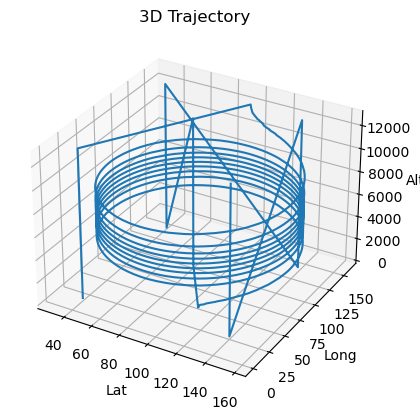

In [244]:

xr_traj_env = xr.concat([xr_traj_env, 
                         xr_ballon_env.drop('launch')],
                           dim='time').sortby('time')
#plot 3d trajectory of z by x and y

def plot_traj_3d(xarray=None):
    xr_x= xarray
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xr_x.lat,
            xr_x.long,
            xr_x.alt)
    ax.set_xlabel('Lat')
    ax.set_ylabel('Long')
    ax.set_zlabel('Alt')
    ax.set_zlim(0, xr_x.alt.max())
    plt.title('3D Trajectory')
    plt.show()

 

plot_traj_3d(xr_traj_env)

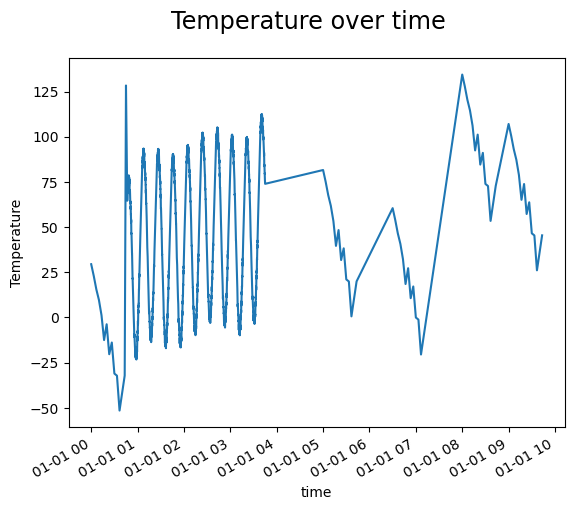

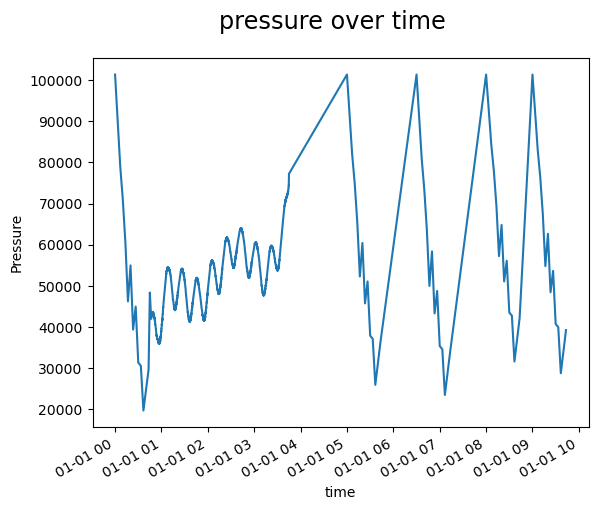

In [245]:

xr_traj_env.Temperature.plot()
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
xr_traj_env.Pressure.plot()
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()



# downsample from xarray


In [258]:
xr_traj_env.reset_coords(['lat','long','alt'], drop=False).resample(time='5min', restore_coord_dims=True).mean().dropna(dim='time')

<xarray.Dataset>
Dimensions:      (time: 81)
Coordinates:
  * time         (time) datetime64[ns] 1970-01-01 ... 1970-01-01T09:40:00
Data variables:
    long         (time) float64 15.0 15.0 15.0 15.0 15.0 ... 25.0 25.0 25.0 25.0
    alt          (time) float64 500.0 2e+03 3.5e+03 ... 9.5e+03 1.1e+04 1.25e+04
    lat          (time) float64 40.0 40.0 40.0 40.0 ... 140.0 140.0 140.0 140.0
    Temperature  (time) float64 26.19 15.76 5.442 -8.761 ... 45.96 30.91 40.6
    Pressure     (time) float64 9.583e+04 7.959e+04 ... 3.152e+04 3.664e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00

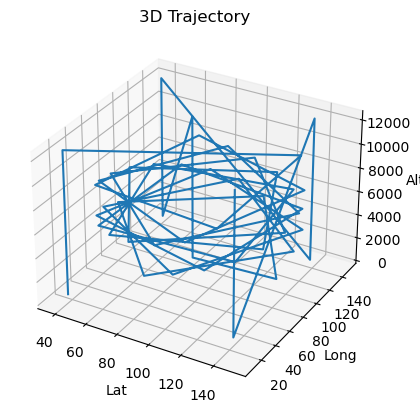

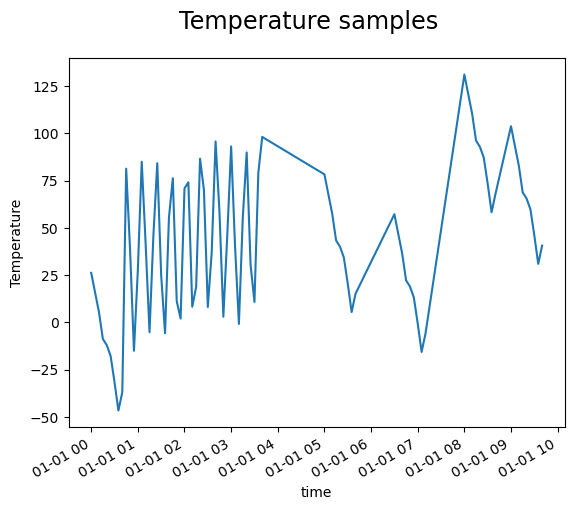

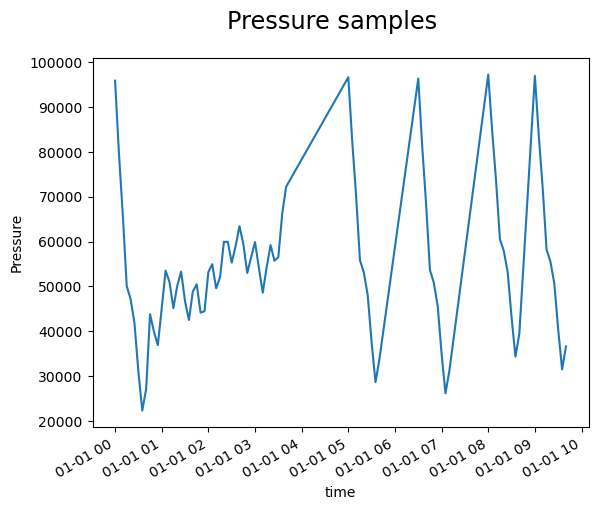

In [259]:

#must be a datetime index in xarray
# move xarray coordinate to variable
xr_traj_env_time = xr_traj_env.reset_coords(['lat','long','alt'], drop=False)
xr_traj_env_time = xr_traj_env_time.resample(time='5min', restore_coord_dims=True).mean().dropna(dim='time')
xr_traj_env_time_coords = xr_traj_env_time
#Move variable to xarray coordinate
xr_traj_env_time = xr_traj_env_time.drop(['lat','long','alt'])
xr_traj_env_time = xr_traj_env_time.expand_dims({"lat":xr_traj_env_time_coords.lat.values, 
                              'long':xr_traj_env_time_coords.long.values, 
                              'alt':xr_traj_env_time_coords.alt.values}) 


plot_traj_3d(xr_traj_env_time)
plt.show()

xr_traj_env_time_coords.Temperature.plot()
plt.suptitle('Temperature samples', fontsize = 'xx-large')
plt.show()
xr_traj_env_time_coords.Pressure.plot()
plt.suptitle('Pressure samples', fontsize = 'xx-large')
plt.show()
# toDO CHANGE THIS VARIABLE BELOW HERE
#xarray make a multiindex of lat long alt and time

#grp_traj_env = 
# may be useful : xr_traj_env_time.stack(alt_lat_long_time=['alt','lat','long','time'],create_index=True)


In [260]:
#xr_traj_env_time wher Temperature is between 26 and 27 degrees
xr_traj_env_time_coords.Temperature.where((xr_traj_env_time.Temperature>26) & (xr_traj_env_time.Temperature<27)).sel(alt=500, lat=40, long=15)[0,:,:,0]

<xarray.DataArray 'Temperature' (lat: 9, long: 9)>
array([[26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539],
       [26.19255539, 26.19255539, 26.19255539, 26.19255539, 26.19255539,
        26.19255539, 26.19255539, 26.19255539, 26.19255539]])
Coordinates:
    time     datetime64[ns] 1970-01-01
  * lat      (lat) float64 40.0 40.0 40.0 40.0 40.0 40.0 40.0 40.0 40.0
  * long     (long) float64 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0 15.0
    alt      float64 500.0


# # Using average values per time period along release; TODO: find more principled way to remove autocorrelation 



# # Model temp and pressure varying by altitude, lat, & long


In [161]:
#standardize the data

def standardize(xarray=None):
    xr_x = xarray
    revert_mean, revert_std = xr_x.mean(), xr_x.std()
    xr_x = (xr_x - xr_x.mean()) / xr_x.std()
    return xr_x, revert_mean, revert_std
def revert_standardize(xarray=None, revert_mean=None, revert_std=None):
    xr_x = xarray
    xr_x = xr_x * revert_std + revert_mean
    return xr_x

xr_traj_env_time_scaled['lat'], sdz_mean, stz_std = standardize(xr_traj_env_time.lat)
xr_traj_env_time_scaled.attrs['sdz_lat_mean'] =sdz_mean.values
xr_traj_env_time_scaled.attrs['sdz_lat_std']  =stz_std.values
xr_traj_env_time_scaled['long'], sdz_mean, stz_std = standardize(xr_traj_env_time.long)
xr_traj_env_time_scaled.attrs['sdz_long_mean'] =sdz_mean.values
xr_traj_env_time_scaled.attrs['sdz_long_std']  =stz_std.values
xr_traj_env_time_scaled['alt'], sdz_mean, stz_std = standardize(xr_traj_env_time.alt)
xr_traj_env_time_scaled.attrs['sdz_alt_mean'] =sdz_mean.values
xr_traj_env_time_scaled.attrs['sdz_alt_std']  =stz_std.values

xr_traj_env_time_scaled

<xarray.Dataset>
Dimensions:      (lat: 81, long: 81, alt: 81, time: 81)
Coordinates:
  * lat          (lat) float64 -1.194 -1.194 -1.194 -1.194 ... 1.121 1.121 1.121
  * long         (long) float64 -1.234 -1.234 -1.234 ... -1.234 -1.234 -1.234
  * alt          (alt) float64 -1.972 -1.479 -0.9854 ... 0.9887 1.482 1.976
  * time         (time) datetime64[ns] 1970-01-01 ... 1970-01-01T09:40:00
Data variables:
    Temperature  (lat, long, alt, time) float64 6.013 -4.415 ... -51.47 -41.78
    Pressure     (lat, long, alt, time) float64 9.545e+04 7.82e+04 ... 2.652e+04
Attributes:
    units:          seconds since 1970-01-01 00:00:00
    sdz_long_mean:  81.40360109412816
    sdz_long_std:   53.828419393824035
    sdz_lat_mean:   91.5677475249025
    sdz_lat_std:    43.189782055673376
    sdz_alt_mean:   6494.924284670781
    sdz_alt_std:    3039.43349223362

In [162]:
xr_traj_env_time.lat.mean()

<xarray.DataArray 'lat' ()>
array(91.56774752)

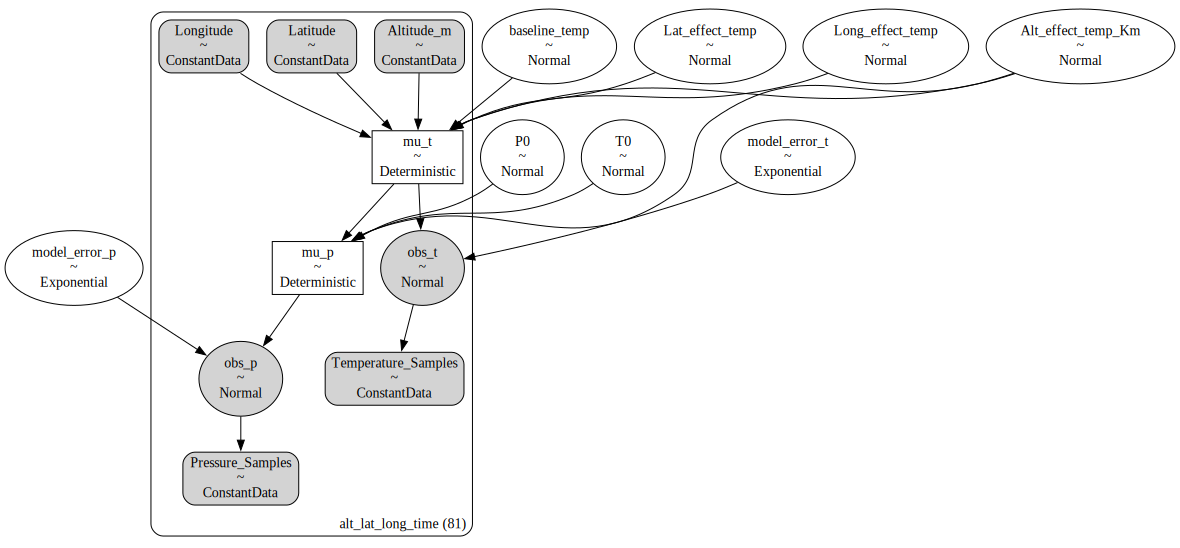

In [196]:

coords={'alt_lat_long_time':
                      np.arange(xr_traj_env_time.sizes['time'], dtype=int)
                      }
with pm.Model(coords=coords) as thermal_pres:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', xr_traj_env_time_coords.alt.values,#[bin_item.mid for bin_item in grp_traj_env.alt_bins.values], 
                                          dims='alt_lat_long_time' )
    Lat_ = pm.ConstantData('Latitude', xr_traj_env_time_scaled.lat.values,# [bin_item.mid for bin_item in grp_traj_env.lat_bins.values],
                                        dims='alt_lat_long_time' )
    Long_ = pm.ConstantData('Longitude', xr_traj_env_time_scaled.long.values,#[bin_item.mid for bin_item in grp_traj_env.long_bins.values],
                                          dims='alt_lat_long_time' )
    Temp_ = pm.ConstantData('Temperature_Samples', xr_traj_env_time_coords.Temperature.values, dims='alt_lat_long_time' )
    Pres_ = pm.ConstantData('Pressure_Samples', xr_traj_env_time_coords.Pressure.values, dims='alt_lat_long_time' )
    #prior on effect on temp (degC) of altitude and lat, long
    baseline_temp = pm.Normal('baseline_temp', mu=20, sigma=5) #'L'
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=-6, sigma=1.5)
    Lat_effect_temp = pm.Normal('Lat_effect_temp', mu=0, sigma=10)
    Long_effect_temp = pm.Normal('Long_effect_temp', mu=0, sigma=10)
    Lat_Long_effect_temp = 0  #pm.Normal('Lat_Long_effect_temp', mu=0, sigma=1)
    #prior on temp and pressure
    #TODO: PULL FROM DATABASE into a pm.Interpolated...maybe not: need relationship between data spreads?
    mu_t = pm.Deterministic('mu_t',
                               baseline_temp + 
                               Alt_effect_temp/1000 * Alt_ + 
                               Lat_effect_temp * Lat_ + 
                               Long_effect_temp * Long_ + 
                               Lat_Long_effect_temp * Lat_ * Long_, 
                               dims='alt_lat_long_time')
    #mu_t = hierarchical_normal('temperature_mean', mu= mu_mu_t, sigma = 2, dims='alt_lat_long_time')
    #mu_p = hierarchical_normal('pressure_mean', 
    P0 = pm.Normal('P0', mu=1, sigma=.01)*101_325.00 # Pres_[0]#101_325.00
    g0 = 9.80665
    M = 0.0289644
    R = 8.3144598
    # NOTE: Temp_[0] is not the lowest altitude tempreture, but the first tempreture in the array
    Temp_0 = pm.Normal('T0', mu=1, sigma=.01)*23
    mu_p= pm.Deterministic('mu_p',P0 *  ((mu_t+273.15)/(Temp_0+273.15)) ** (g0 * M / (R * (-Alt_effect_temp/1000))), #needed negative b/c the lapse is positive, but use addition in effect
                                 dims='alt_lat_long_time')
    '''add_barometric_effects(T = mu_t,#Temp_, 
                                 L = Alt_effect_temp/1000, H = Alt_,  
                                 P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)'''
    #add_barometric_effects = P0 * (T/T0) ** (g0 * M / (R * L))
    #prior on error variation
    sigma_t=pm.Exponential('model_error_t', 1/5)
    sigma_p=pm.Exponential('model_error_p', 1/5000)
    #adjusted temp - normal dist error term
    obs_t = pm.Normal('obs_t', mu=mu_t, sigma=sigma_t, 
                    observed = Temp_, dims='alt_lat_long_time')
    obs_p = pm.Normal('obs_p', mu=mu_p, sigma=sigma_p,                     observed = Pres_, dims='alt_lat_long_time')
    
pm.model_to_graphviz(thermal_pres)


## Examine the priors selected and their match to the observed

Sampling: [Alt_effect_temp_Km, Lat_effect_temp, Long_effect_temp, P0, T0, baseline_temp, model_error_p, model_error_t, obs_p, obs_t]


array([<Axes: xlabel='obs_t / obs_t'>, <Axes: xlabel='obs_p / obs_p'>],
      dtype=object)

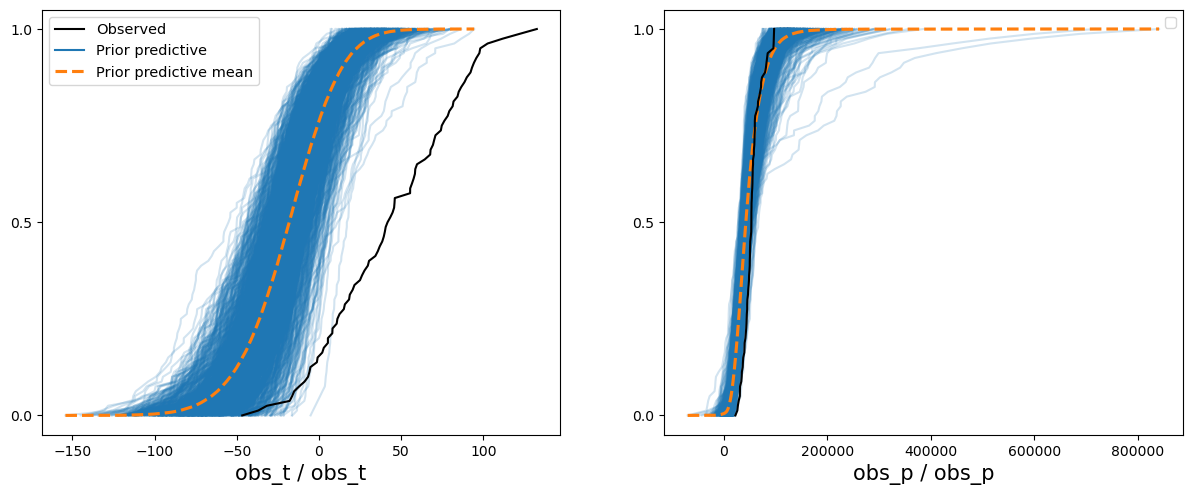

In [197]:
with thermal_pres:
    idata2 = pm.sample_prior_predictive(1000)
az.plot_ppc(idata2, group='prior', kind='cumulative')


## Run MCMC bayesian sampler

In [176]:
with thermal_pres:
    idata2.extend(pm.sample(1000, tune=1000, chains = 4, cores=1))
 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


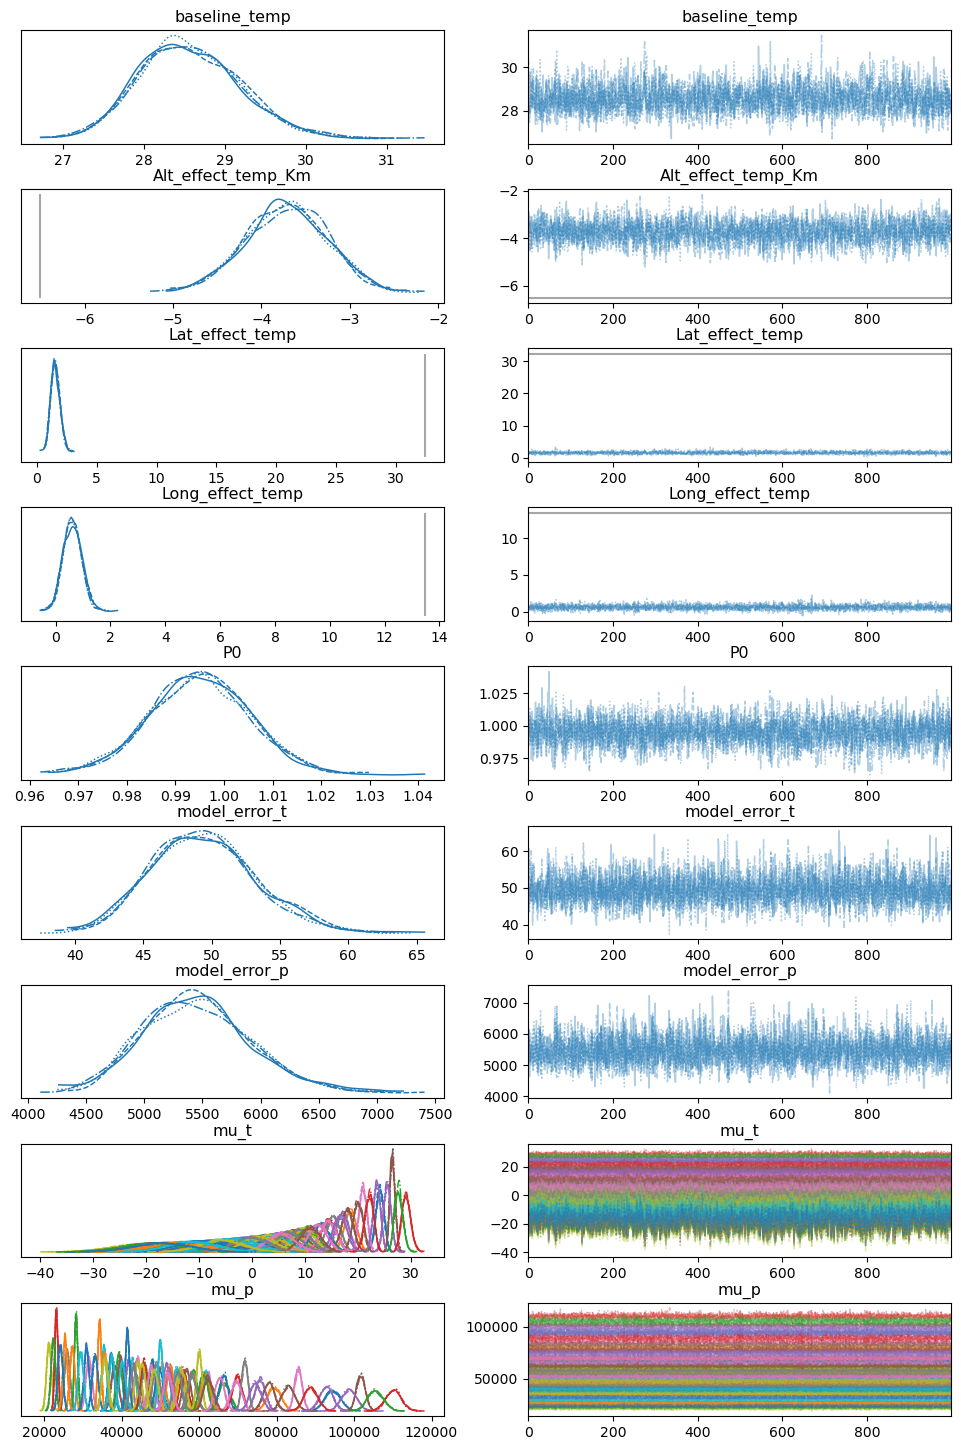

In [177]:
correctsignsize_mean_tempC_Km= -mean_tempC_Km*1000
az.plot_trace(idata2, lines = (('Alt_effect_temp_Km', {},[correctsignsize_mean_tempC_Km]),
                              #('Lat_effect_temp',{}, lat_inc_slope  ),
                              #('Long_effect_temp',{}, long_inc_mu  ), ))
                              #('Lat_effect_temp',{}, lat_inc_slope / xr_traj_env_time_scaled.attrs['sdz_lat_std'] ),
                              #('Long_effect_temp',{}, long_inc_mu / xr_traj_env_time_scaled.attrs['sdz_long_std'] ), ))
                              ('Lat_effect_temp',{}, lat_inc_slope * xr_traj_env_time_scaled.attrs['sdz_lat_std'] ),  #TODO: that multiplication doesn't make sense
                              ('Long_effect_temp',{}, long_inc_mu * xr_traj_env_time_scaled.attrs['sdz_long_std'] ), ))

plt.subplots_adjust (hspace=0.4)#, wspace=0.4)

In [178]:
idx_sortby_alt = xr.DataArray(idata2.constant_data.sortby('Altitude_m', ascending=False).alt_lat_long_time.values,
                                dims=['alt_lat_long_time'])
idata2.posterior = idata2.posterior.sortby( idx_sortby_alt) #posterior only for now
idata2.constant_data = idata2.constant_data.sortby('Altitude_m', ascending=False)
idata2.constant_data.alt_lat_long_time.values

array([80, 71, 62, 53,  8, 79, 70, 61, 52,  7,  9, 78, 69, 60, 51,  6, 10,
       11, 12, 13, 77, 68, 59, 50,  5, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 76, 67, 58, 49,  4, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 75, 66, 57, 48,  3, 39, 40, 41, 42, 43, 44, 74, 65,
       56, 47,  2, 73, 64, 55, 46,  1, 72, 63, 54, 45,  0])

In [179]:
#xarray filter by values - used in grouping graphs
lat_min = idata2.constant_data.Latitude.min()
lat_max = idata2.constant_data.Latitude.max()
long_min = idata2.constant_data.Longitude.min()
long_max = idata2.constant_data.Longitude.max()
lat_mid = (lat_min + lat_max)/2
long_mid = (long_min + long_max)/2

idx_north = idata2.constant_data.where(idata2.constant_data.Latitude>lat_mid, drop=True).alt_lat_long_time.values
idx_south = idata2.constant_data.where(idata2.constant_data.Latitude<lat_mid, drop=True).alt_lat_long_time.values
idx_east = idata2.constant_data.where(idata2.constant_data.Longitude>long_mid, drop=True).alt_lat_long_time.values
idx_west = idata2.constant_data.where(idata2.constant_data.Longitude<long_mid, drop=True).alt_lat_long_time.values


In [180]:
# creating class for labeling the altitude instead of variable index
class DimCoordLabeller_alt(azl.BaseLabeller):
    """WIP."""
    def __init__(self, coords_ds):
        self.coords_ds = xr.Dataset(coords)

    def dim_coord_to_str(self, dim, coord_val, coord_idx):
        """WIP."""#format decimals in f statement
        temp =  self.coords_ds.sel(pointwise_sel=coord_val).items()
        temp = [(v.values) for _,v in temp][0]
        return f"{temp:.2f}" 
    
coords = {
    'alt_lat_long_time': xr.DataArray(
        idata2.constant_data.Altitude_m.values, 
        dims=['pointwise_sel'],coords={'pointwise_sel': idata2.constant_data.alt_lat_long_time.values}
    )
}        
labeller = DimCoordLabeller_alt(coords)


North West
North East
South West
South East


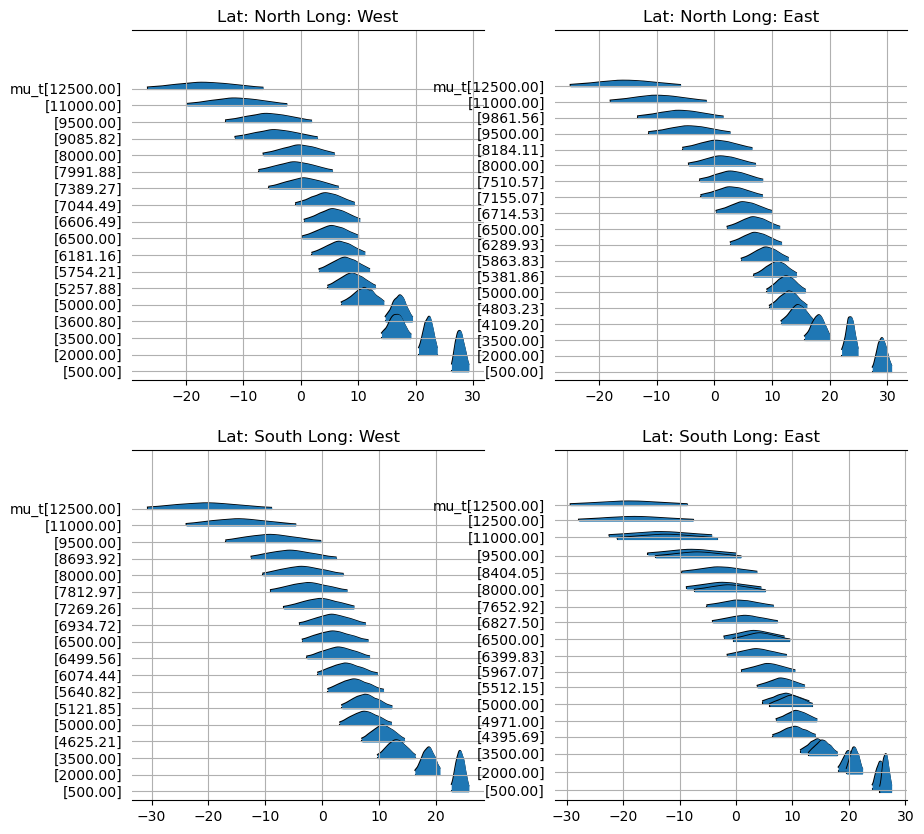

In [181]:
#figures with lat in coulmns and long in rows
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
for i, ((N_S_label,N_S_idx), (E_W_label,E_W_idx)) in enumerate([[i,j] 
                                  for i in [('North',idx_north),('South',idx_south)] 
                                  for j in [('West',idx_west), ('East',idx_east)]]):
    print(N_S_label,E_W_label)
    ax[i].set_title(f'Lat: {N_S_label} Long: {E_W_label}')
    idx = np.intersect1d(N_S_idx,E_W_idx)
    az.plot_forest(idata2.sel(alt_lat_long_time=[x for x in idx_sortby_alt 
                                                 if np.any(np.isin(idx,x))]),
                   var_names=['mu_t'],
                   kind='ridgeplot', 
                   combined=True, ax= ax[i],
                   labeller=labeller
                   )
    #align the y axis
    #ax[i].set_ylim(0, 10000)
    #ax[i].set_xlim(-70, 10)
    ax[i].grid()


array([<Axes: >], dtype=object)

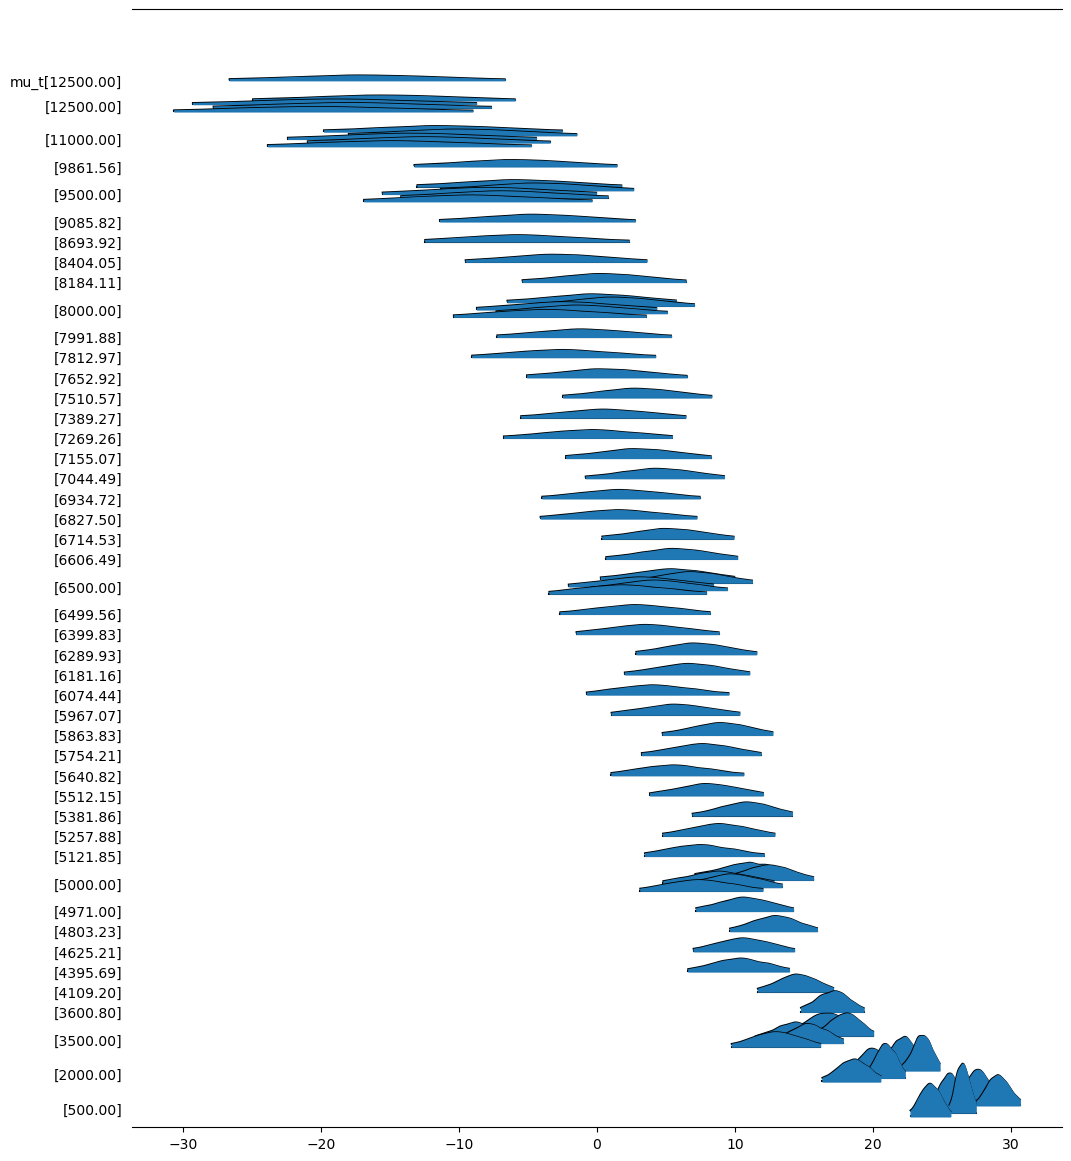

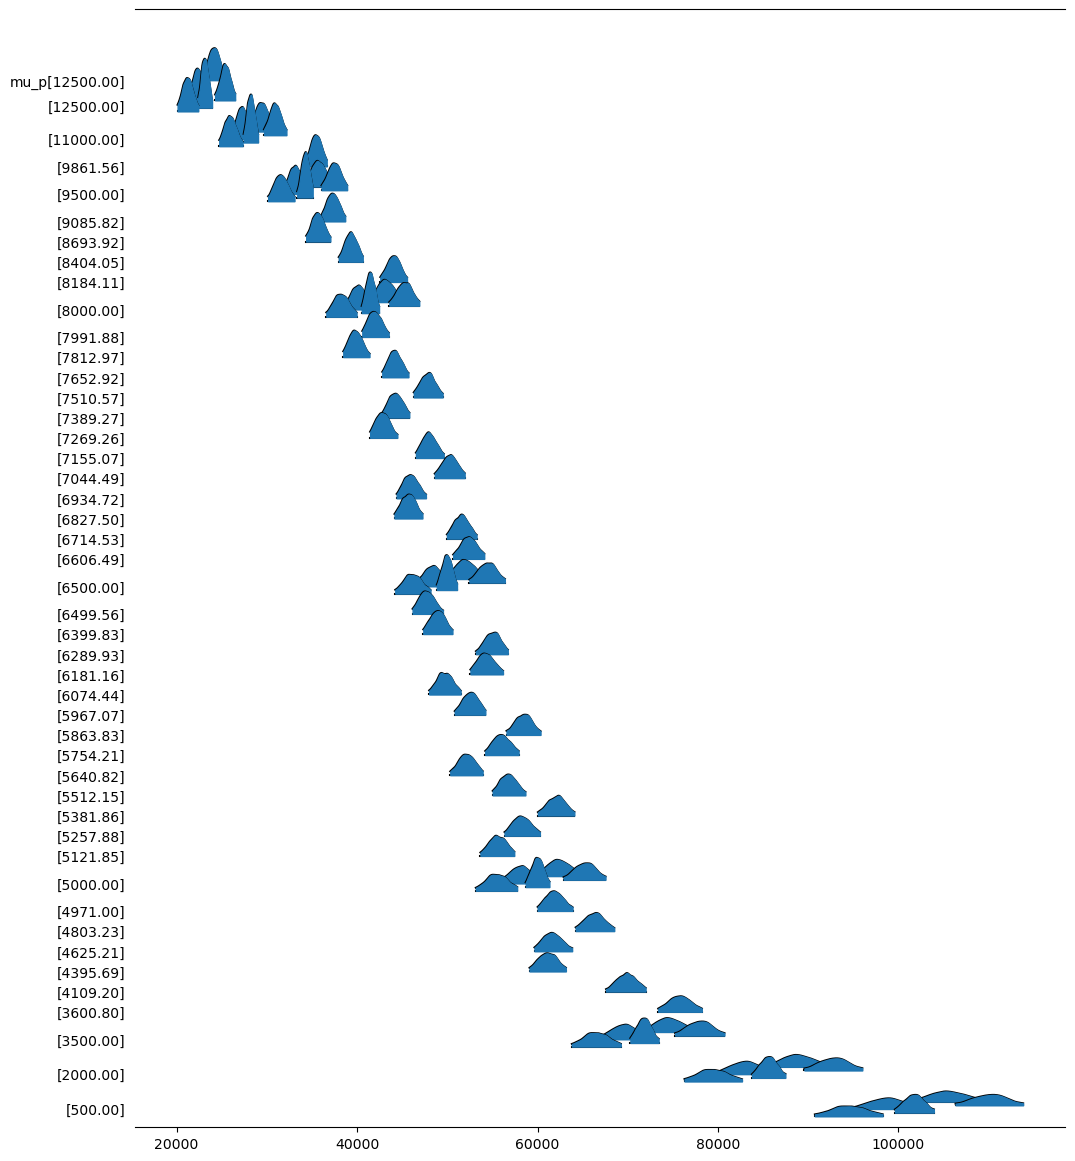

In [182]:
az.plot_forest(idata2.sel( alt_lat_long_time=idx_sortby_alt), var_names=['mu_t'],kind='ridgeplot', combined=True,labeller=labeller)
az.plot_forest(idata2.sel( alt_lat_long_time=idx_sortby_alt), var_names=['mu_p'],kind='ridgeplot', combined=True,labeller=labeller)


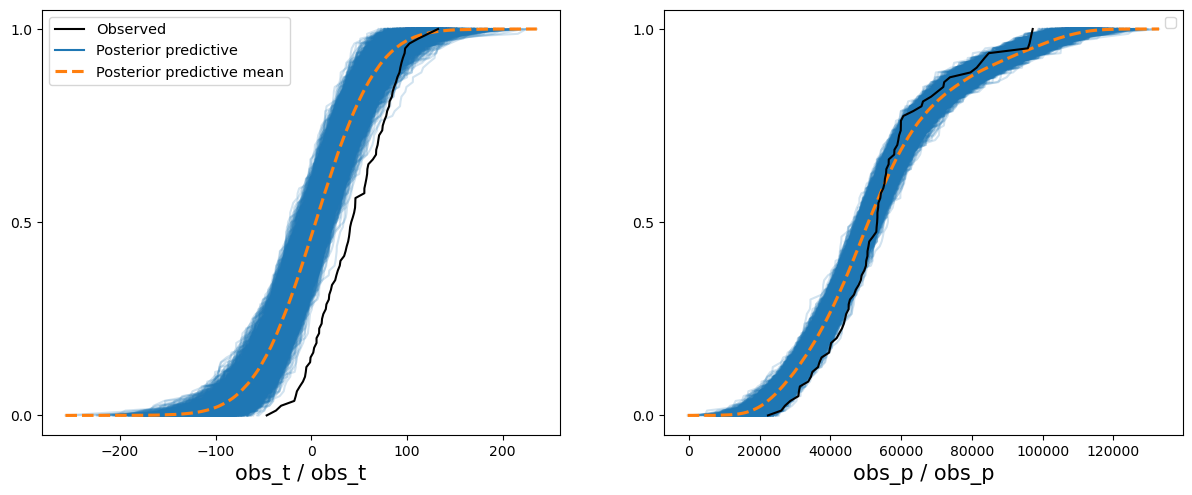

In [183]:

with thermal_pres:
    # pymc sample posterior predictive check
    pm.sample_posterior_predictive(idata2, extend_inferencedata=True)
    az.plot_ppc(idata2, group='posterior', kind='cumulative')


c:\Users\willi\OneDrive\Documents\GitHub\Weather\.conda\lib\site-packages\arviz\plots\distcomparisonplot.py:160: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of subplots to plot (648), generating only 40 plots
  warnings.warn(
c:\Users\willi\OneDrive\Documents\GitHub\Weather\.conda\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n500.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n2000.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n3500.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n5000.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n6500.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n8000.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n9500.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n11000.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n12500.00'>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='obs_t\n9861.56'>]],
      dtype=object)

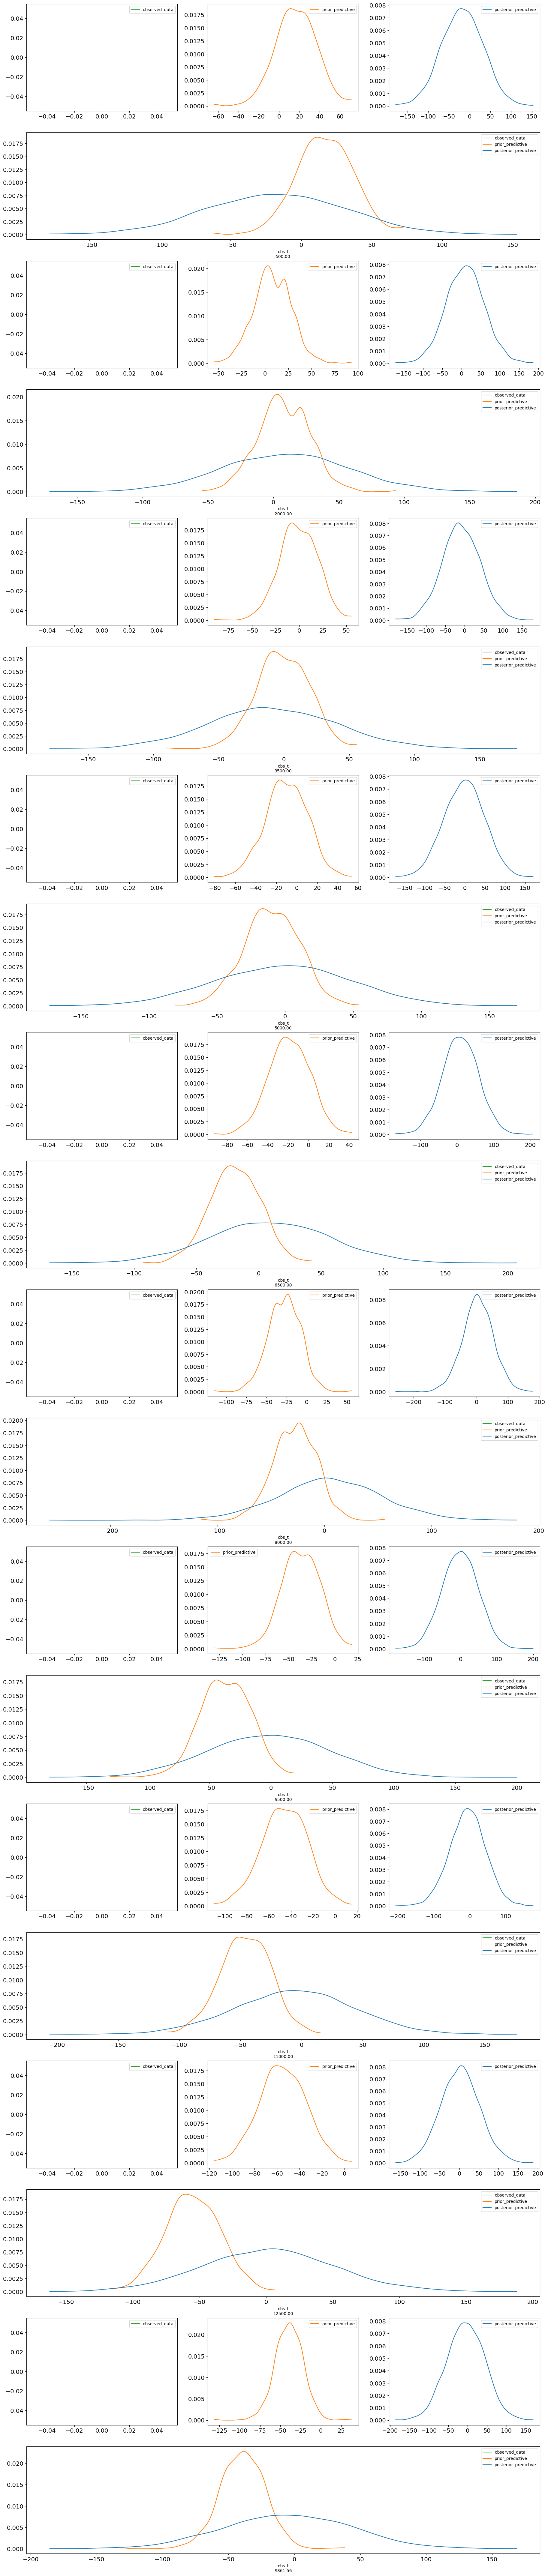

In [184]:

az.plot_dist_comparison(idata2, kind='observed', labeller=labeller)